In [0]:
%matplotlib inline
%load_ext tensorboard
!pip install -q tensorflow==2.0.0-beta1
from __future__ import absolute_import, division, print_function, unicode_literals
import sys, os, datetime, time, scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
from scipy.integrate import quad

### Regression Task

We use the following function for training data with support x∈[0,1]:

<img src="https://i.postimg.cc/VL0tDL5h/Code-Cogs-Eqn-3.png" width="100">

Factors that may affect the results:

1. Distribution of Training set. X is generated with uniform distribution.
2. Structure of NN. 2 layers [5, 1]

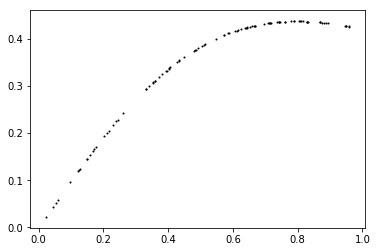

In [0]:
f=lambda x:np.sin(x)/(1+x**2)
x = [np.random.uniform() for i in range(100)]
y = [f(i) for i in x]
plt.scatter(x,y, c='black', s=1)

### Benchmark Errors (MSE only)

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
  plt.ylim([0,np.max(hist['loss'])/50])
  plt.legend()
  plt.show()
  
def build_model(if_print=False):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu', input_shape=[1]),
    tf.keras.layers.Dense(1)])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',optimizer=optimizer)
  if if_print: model.summary()
  return model

def get_data(data_size=10000):
  f=lambda x:np.sin(x)/(1+x**2)
  x = [np.random.uniform() for i in range(data_size)]
  y = [f(i) for i in x]
  return x,y

def get_benchmark_NN(x, y):
  model = build_model(1)
  history = model.fit(x, y, epochs=200, validation_split = 0.2, verbose=0)
  plot_history(history)
   
  return model

def print_model(model):
  model.summary()
  print("layer 1 weights:", ', '.join([str(item) for item in model.layers[0].trainable_variables[0].numpy()]))
  print("layer 1 bias:", ', '.join([str(item) for item in model.layers[0].trainable_variables[1].numpy()]))
  print("layer 2 weights:", ', '.join([str(item) for item in model.layers[1].trainable_variables[0].numpy()]))
  print("layer 2 bias:", ', '.join([str(item) for item in model.layers[1].trainable_variables[1].numpy()]))
    
def print_first_layer(model):
  print("First layer:", ', '.join([str(item) for item in model.layers[0].trainable_variables[0].numpy()]))
    
def get_errors(model, x, y, if_print=False):
  y_pred = model.predict(x)
  y_pred = y_pred.reshape(-1)
  errors = y - y_pred
  #errors = [np.abs(i) for i in errors]
  mean = np.mean(errors)
  sigma = np.sqrt(np.var(errors))
  if if_print:
    print("\nmean of errors:", mean)
    print("standard deviation of errors:", sigma)
  
  return errors, mean, sigma

#x, y = get_data(1000)
#model = get_benchmark_NN(x, y)
#errors, mean, sigma = get_errors(model, x, y, if_train=1, if_print_weights=1, if_print_errors_stats=1)

In [0]:
def get_kde(errors):
  kde=stats.gaussian_kde(errors)
  kde.set_bandwidth(bw_method=kde.factor/10)
  return kde
def plot_errors(errors):
  errors_sigma = np.sqrt(np.var(errors))
  plt.figure(figsize=(20, 8))
  plt.xticks(fontsize=10)
  plt.subplots_adjust(hspace=1)

  p1 = plt.subplot(311)
  p1.title.set_text("Errors Histogram")
  weights = np.ones_like(errors)/float(len(errors))
  _, _, _ = plt.hist(errors, weights=weights,bins=100, color='red')

  p2 = plt.subplot(312)
  p2.title.set_text('Errors PDF')

  x1 = np.linspace(np.min(errors), np.max(errors), num=10000)
  kde = get_kde(errors)
  y1 = kde(x1)
  plt.plot(x1, y1, color='black', linewidth=1)
  plt.plot(errors, np.full_like(errors, -0.1), '|k', markeredgewidth=1)

  p3 = plt.subplot(313)
  p3.title.set_text("Normal Distribution")
  y_norm = stats.norm.pdf(x1, 0, errors_sigma/4)
  plt.plot(x1, y1, x1, y_norm, color='black', linewidth=1)
  plt.fill_between(x1, y1, y_norm, where=y_norm >= y1, facecolor='blue', interpolate=True)
  plt.fill_between(x1, y1, y_norm, where=y_norm <= y1, facecolor='red', interpolate=True)

#plot_errors(errors)

### Benchmark Loss (Target Normal)

In [0]:
def normal_distribution_function(x,mean,std):
  value = scipy.stats.norm.pdf(x,mean,std)
  return value
  
def kde_function(x, errors):
  kde = get_kde(errors)
  value = kde(x)
  return value
  
def find_nearest(array, value):
  array = np.asarray(array)
  idx = (np.abs(array - value)).argmin()
  return array[idx], idx
  
def get_loss(errors, if_print=False, if_plot=False):
  
  errors_sigma = np.sqrt(np.var(errors))
  x1 = np.linspace(np.min(errors), np.max(errors), num=10000)

  kde = get_kde(errors)
  y_norm = stats.norm.pdf(x1, 0, errors_sigma/4)
  y1 = kde(x1)
  idx = np.argwhere(np.diff(np.sign(y_norm - y1))).flatten()
  
  x1_0, x1_0_idx = find_nearest(x1,0)
  crosspoint_1_idx, tmp = find_nearest(idx, x1_0_idx)
  idx = np.delete(idx, tmp, 0)
  crosspoint_2_idx, _ = find_nearest(idx, x1_0_idx)
  crosspoint_1, crosspoint_2 = x1[crosspoint_1_idx], x1[crosspoint_2_idx]
  if crosspoint_1 > crosspoint_2:
    crosspoint_1, crosspoint_2=crosspoint_2, crosspoint_1
    crosspoint_1_idx, crosspoint_2_idx=crosspoint_2_idx, crosspoint_1_idx
    
  norm_area, norm_err = quad(normal_distribution_function, crosspoint_1, crosspoint_2, args=(0,errors_sigma/4,))
  kde_area, kde_err = quad(kde_function, crosspoint_1, crosspoint_2, args=(errors))
  
  if if_print:
    print("Errors Min:", np.min(errors), ", Errors Max:", np.max(errors))
    print("Crosspoint Index:", crosspoint_1_idx, "and", crosspoint_2_idx, "out of 10000 points")
    print("\nLeft crosspoint:", crosspoint_1, ", Right crosspoint:", crosspoint_2)
    print("Area of Normal (between the crosspoints):", norm_area)
    print("Area of Errors (between the crosspoints):", kde_area)
    print("Loss(blue area):", norm_area-kde_area)
    
  if if_plot:
    plt.figure(figsize=(20, 4))
    plt.xticks(fontsize=10)
    plt.subplots_adjust(hspace=0.3)

    p1 = plt.subplot(211)
    diffs=[np.abs(stats.norm.pdf(i, 0, errors_sigma/4)-kde(i))[0] for i in x1]
    p1.plot(x1, diffs)
    p1.scatter(np.array([crosspoint_1, crosspoint_2]), np.array([diffs[crosspoint_1_idx],diffs[crosspoint_2_idx]]), color="black")
    plt.xlim(np.min(errors), np.max(errors))
    p1.title.set_text("Difference between Normal and Errors")

    p2 = plt.subplot(212)
    y_norm = stats.norm.pdf(x1, 0, errors_sigma/4)
    p2.plot(x1, y1, x1, y_norm, color='black', linewidth=1)
    p2.fill_between(x1, y1, y_norm, where=y_norm >= y1, facecolor='blue', interpolate=True)
    p2.fill_between(x1, y1, y_norm, where=y_norm <= y1, facecolor='red', interpolate=True)
    idx1=np.where(crosspoint_1)
    xs = np.array([crosspoint_1, crosspoint_2])
    ys = np.array([y1[crosspoint_1_idx],y1[crosspoint_2_idx]])
    p2.scatter(xs, ys, color="black")
    plt.xlim(np.min(errors), np.max(errors))
    
  return norm_area-kde_area

#benchmark_loss = get_loss(model, errors, if_print=1, if_plot=1)

In [0]:
def get_loss(errors):
  def normal_minus_kde(x, mean, std, errors):
    kde = get_kde(errors)
    value = np.abs(scipy.stats.norm.pdf(x,mean,std) - kde(x))
    return value
  errors_sigma = np.sqrt(np.var(errors))
  loss, err = quad(normal_minus_kde, np.min(errors), np.max(errors), args=(0, errors_sigma/4, errors))
  return loss

### Approximate Gradient

In [14]:
def node_plus_delta(model, layer_n, wb_n, node_n, if_print=False, delta = 10**(-6)):

  weight_old = model.layers[layer_n].trainable_variables[wb_n].numpy()
  delta_extend = np.zeros(weight_old.shape)
  
  if layer_n == 0:
    if wb_n==0:
      delta_extend[0][node_n] = delta
    elif wb_n==1:
      delta_extend[node_n] = delta
  elif layer_n == 1:
    if wb_n==0:  
      delta_extend[node_n] = delta
    elif wb_n==1:
      delta_extend = delta
      
  weight_new = weight_old + delta_extend
  if if_print: print("\n OLD: model.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
  model.layers[layer_n].trainable_variables[wb_n].assign(weight_new)
  if if_print: print("\n NEW: model.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
    
  return model

def node_minus_delta(model, layer_n, wb_n, node_n, if_print=False, delta = 10**(-6)):
  weight_old = model.layers[layer_n].trainable_variables[wb_n].numpy()
  delta_extend = np.zeros(weight_old.shape)

  if layer_n == 0:
    if wb_n==0:
      delta_extend[0][node_n] = delta
    elif wb_n==1:
      delta_extend[node_n] = delta
  elif layer_n == 1:
    if wb_n==0:  
      delta_extend[node_n] = delta
    elif wb_n==1:
      delta_extend = delta
    
  weight_new = weight_old - delta_extend
  if if_print: print("\nmodel.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
  model.layers[layer_n].trainable_variables[wb_n].assign(weight_new)
  if if_print: print("\nmodel.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
  return model

def node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n, delta_n=1):
  for i in range(delta_n):
    model = node_plus_delta(model, layer_n, wb_n, node_n, if_print=0)
  errors, mean, var = get_errors(model, x, y)
  loss = get_loss(errors)
  
  #for i in range(delta_n):
    #node_minus_delta(model, layer_n, wb_n, node_n)
  return loss

def check_node_loss(model, x, y, layer_n, wb_n, node_n, benchmark_loss):
  node_loss = node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n)
  delta_n = 1
  n=0
    
  #print("\nBEGIN of check_node_loss(), layer_n, wb_n, node_n:", layer_n, wb_n, node_n)
  #print_first_layer(model)
  
  while benchmark_loss == node_loss and n<10: 
    n+=1
    delta_n+=1
    node_loss = node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n, delta_n)
  
    if n==10:
      while benchmark_loss == node_loss and n<20: 
        n+=1
        delta_n+=10
        node_loss = node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n, delta_n)

    if n==20:
      while benchmark_loss == node_loss and n<30: 
        n+=1
        delta_n+=100
        node_loss = node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n, delta_n)

    if n==30:
      while benchmark_loss == node_loss and n<40: 
        n+=1
        delta_n+=1000
        node_loss = node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n, delta_n)
  
  #print("END of node_plus_delta(), delta_n:", delta_n)
  #print_first_layer(model)
  #print("\n")
  
  return node_loss, delta_n

def nodes_plus_delta_loss(model, x, y, benchmark_loss):
  layer_0_w_losses = []
  layer_0_b_losses = []
  layer_1_w_losses = []
  layer_1_b_losses = []
  
  layer_0_w_delta_n = []
  layer_0_b_delta_n = []
  layer_1_w_delta_n = []
  layer_1_b_delta_n = []
  
  #print("-----")
  for i in range(5):
    loss, delta_n = check_node_loss(model, x, y, 0, 0, i, benchmark_loss=benchmark_loss)
    layer_0_w_losses.append(loss)
    layer_0_w_delta_n.append(delta_n)
    #print(i)
  
  #print("-----")
  for i in range(5):
    loss, delta_n = check_node_loss(model, x, y, 0, 1, i, benchmark_loss=benchmark_loss)
    layer_0_b_losses.append(loss)
    layer_0_b_delta_n.append(delta_n)
    #print(i)
  
  #print("-----")
  for i in range(5):
    loss, delta_n = check_node_loss(model, x, y, 1, 0, i, benchmark_loss=benchmark_loss)
    layer_1_w_losses.append(loss)
    layer_1_w_delta_n.append(delta_n)
    #print(i)
   
  loss, delta_n = check_node_loss(model, x, y, 1, 1, 0, benchmark_loss=benchmark_loss)                                
  layer_1_b_losses.append(loss)
  layer_1_b_delta_n.append(delta_n)
  
  nodes_losses = [layer_0_w_losses, layer_0_b_losses, layer_1_w_losses, layer_1_b_losses]
  nodes_delta_n = [layer_0_w_delta_n, layer_0_b_delta_n, layer_1_w_delta_n, layer_1_b_delta_n]
  return nodes_losses,nodes_delta_n

"""
start_time = time.time()
nodes_losses, nodes_delta_n = nodes_plus_delta_loss(model, x, y)
print("--- %s seconds ---" % (time.time() - start_time))
print("benchmark loss:", benchmark_loss)
print("nodes loss:", nodes_losses)
print("nodes_delta_n:", nodes_delta_n)
"""

'\nstart_time = time.time()\nnodes_losses, nodes_delta_n = nodes_plus_delta_loss(model, x, y)\nprint("--- %s seconds ---" % (time.time() - start_time))\nprint("benchmark loss:", benchmark_loss)\nprint("nodes loss:", nodes_losses)\nprint("nodes_delta_n:", nodes_delta_n)\n'

In [0]:
def get_gradient(nodes_losses, nodes_delta_n, benchmark_loss):
  gradients = []
  for i in range(len(nodes_losses)):
    grads = []
    for j in range(len(nodes_losses[i])):
      grad = (nodes_losses[i][j]-benchmark_loss)/(nodes_delta_n[i][j]**10**(-6))
      print("layer[", i, "] - node[", j, "] - node_loss:", nodes_losses[i][j], "benchmark_loss:", benchmark_loss, "grad:", grad)
      grads.append(grad)
    gradients.append(grads)
    
  return gradients

#grads = get_gradient(nodes_losses, nodes_delta_n, benchmark_loss)
#print(grads)

def update_nodes(model, grads, nodes_delta_n, if_print = False, lr = 0.001):
  if if_print: 
    print("\n OLD:")
    print("model.layers[0].trainable_variables[0]:", model.layers[0].trainable_variables[0])
    print("model.layers[0].trainable_variables[1]:", model.layers[0].trainable_variables[1])
    print("model.layers[1].trainable_variables[0]:", model.layers[1].trainable_variables[0])
    print("model.layers[1].trainable_variables[1]:", model.layers[1].trainable_variables[1])
  for i in range(len(grads)):
    for j in range(len(grads[i])):
      delta = lr*grads[i][j]*nodes_delta_n[i][j]*10**(-6)
      print("grad:", grads[i][j])
      print("delta:", delta)
      model = node_plus_delta(model, layer_n=0 if i<2 else 1, wb_n=i%2, node_n=j, delta = -delta)
      
  if if_print: 
    print("\n NEW:")
    print("model.layers[0].trainable_variables[0]:", model.layers[0].trainable_variables[0])
    print("model.layers[0].trainable_variables[1]:", model.layers[0].trainable_variables[1])
    print("model.layers[1].trainable_variables[0]:", model.layers[1].trainable_variables[0])
    print("model.layers[1].trainable_variables[1]:", model.layers[1].trainable_variables[1])
    
  return model

#model=update_nodes(model, grads, nodes_delta_n, if_print=0)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 6         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


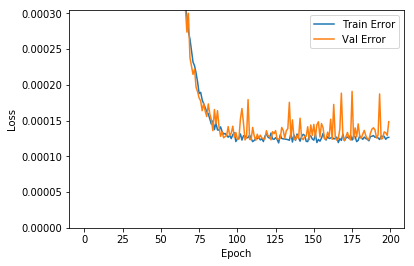

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 6         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
layer 1 weights: [-0.68631554  1.0809374   1.0051358   0.37680265 -0.45187235]
layer 1 bias: 0.0, 0.009723945, -0.48107508, 0.010006868, 0.0
layer 2 weights: [0.244982], [0.5113699], [-0.7076647], [0.6611701], [0.75307083]
layer 2 bias: 0.010891179

mean of errors: -0.0043030132998867375
standard deviation of errors: 0.011058002584469588
Errors Min: -0.032610644557364454 , Errors Max: 0.009898531332534127
Crosspoint Index: 6540 and 8675 out of 10000 points

Left crosspoint: -0.0048068631472297715 , Right crosspoint

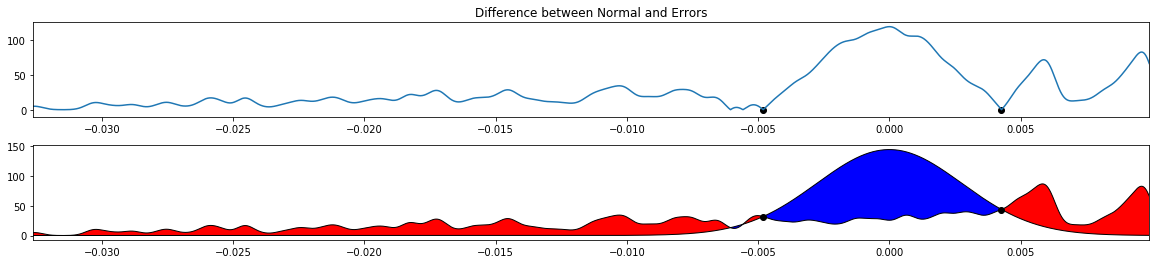

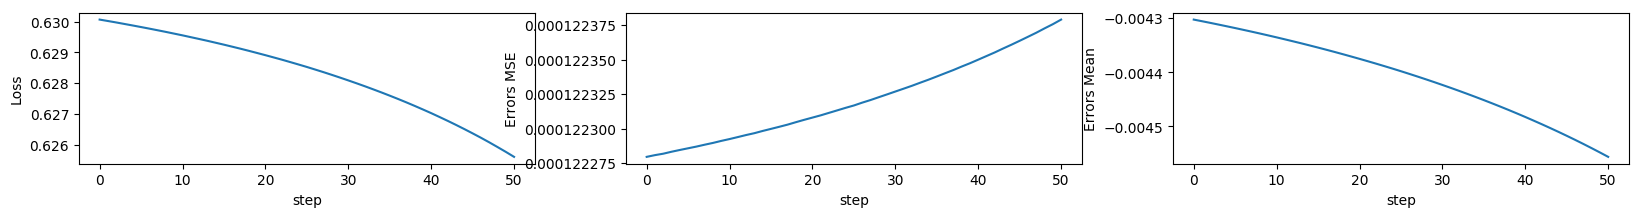

In [30]:
def train_dist(step_n=50):
  
  x, y = get_data(500)
  #x_val, y_val = get_data(200)
  model = get_benchmark_NN(x, y)
  print_model(model)
  errors, mean, sigma = get_errors(model, x, y, if_print=1)
  errors_first = errors
  #print("\n----------------ERRORS-first\n", errors_first, "\n")
  #plot_errors(errors)
  benchmark_loss = get_loss(errors, if_print=1, if_plot=1)
  #print("\nInitial loss:", benchmark_loss)
  
  lr_init = 400
  lr = lr_init
  losses=[]; errors_mses=[]; errors_means=[]
  losses.append(benchmark_loss); errors_mses.append(sigma**2); errors_means.append(mean)
  for i in range(step_n):
    print("-----Step", i)
    if i < (step_n-1): if_print=0
    else: if_print=0
      
    # estimate gradient
    nodes_losses, nodes_delta_n = nodes_plus_delta_loss(model, x, y, benchmark_loss)
    grads = get_gradient(nodes_losses, nodes_delta_n, benchmark_loss)
    
    # update weights
    model = update_nodes(model, grads, nodes_delta_n, if_print=if_print, lr=lr)
    
    errors, mean, sigma = get_errors(model, x, y, if_print=if_print)
    new_loss = get_loss(errors, if_print=if_print, if_plot=if_print)
    losses.append(new_loss)
    errors_mses.append(sigma**2)
    errors_means.append(mean)
    print("New loss:", new_loss, "    (learning rate:", lr, ")")
    #print_first_layer(model)
    #lr = lr_init*2**(-i//10)
  
  print_model(model)
  errors_last = errors
  #print("\n----------------ERRORS-last:\n", errors_last, "\n")
  #plot losses, errors mean, errors variance
  xs = np.arange(step_n+1)

  plt.figure(dpi=100, figsize=(20, 2))
  plt.xticks(fontsize=10)
  plt.subplots_adjust(wspace=0.2)

  p1 = plt.subplot(131)
  p1.plot(xs, losses)
  plt.xlabel("step")
  plt.ylabel("Loss")
  
  p2 = plt.subplot(132)
  p2.plot(xs, errors_mses)
  plt.xlabel("step")
  plt.ylabel("Errors MSE")

  p3 = plt.subplot(133)
  p3.plot(xs, errors_means)
  plt.xlabel("step")
  plt.ylabel("Errors Mean")

  return losses, errors_mses, errors_means, errors_first, errors_last, grads
  
start_time = time.time()
losses, errors_mses, errors_means, errors_first, errors_last, last_grads = train_dist()
print("--- %s seconds ---" % (time.time() - start_time))

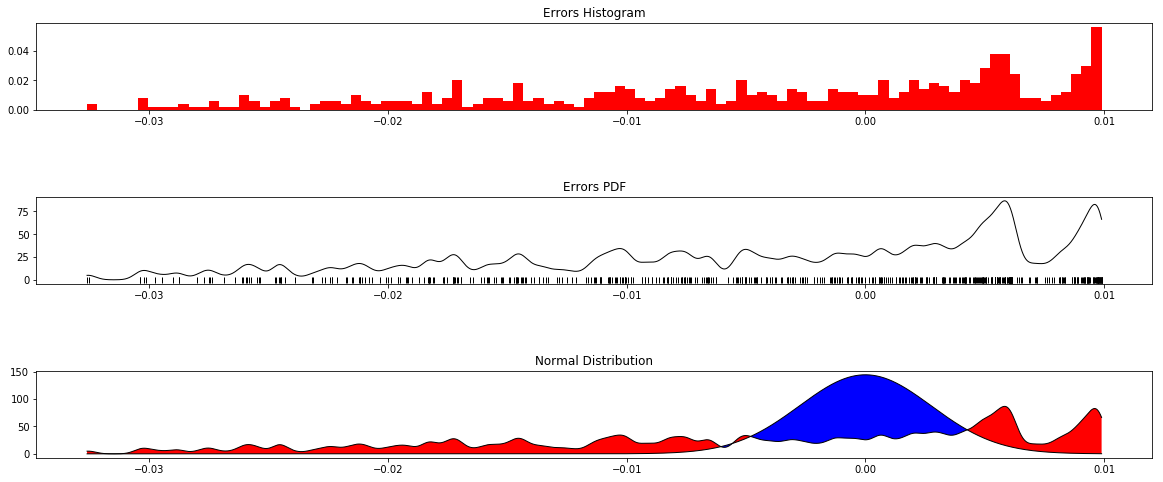

In [31]:
plot_errors(errors_first)

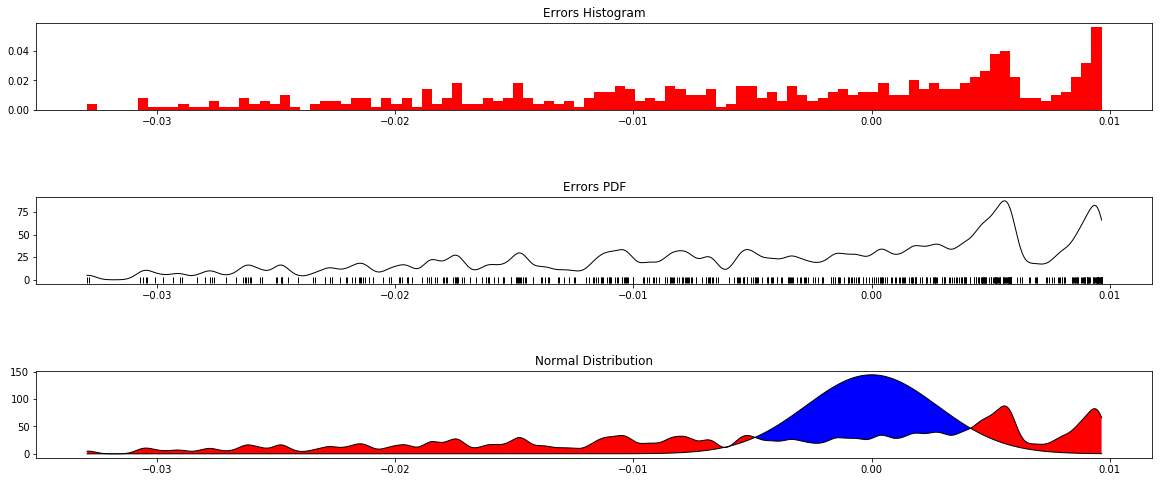

In [32]:
plot_errors(errors_last)

In [18]:
losses

[0.6847697230729098,
 0.6846750662193342,
 0.6845813986405914,
 0.6844878783320228,
 0.6843920554850371,
 0.6842981419141435,
 0.6842037305364643,
 0.684107888466029,
 0.6840124550397192,
 0.6839169052731239,
 0.6838199679504997,
 0.6837230074531949,
 0.6836256346541274,
 0.6835281203179598,
 0.683430633227794,
 0.6833320408620229,
 0.6832333445259327,
 0.6831341109737143,
 0.6830351756740041,
 0.6829352857376707,
 0.6828349070470676,
 0.6827337553604063,
 0.6826332471459784,
 0.6825313094225087,
 0.6824308484041635,
 0.6823289122526323,
 0.6822262120553192,
 0.6821230363563937,
 0.6820199125059985,
 0.6819163250296564,
 0.6818127991859042,
 0.6817091883216565,
 0.6816046918233925,
 0.6814997087397585,
 0.6813958214363135,
 0.6812897541452112,
 0.681185075395647,
 0.6810790319222084,
 0.680972860414832,
 0.6808677940384282,
 0.6807604618017014,
 0.6806537590492205,
 0.6805484920880643,
 0.6804414376941963,
 0.6803353090634077,
 0.6802283137609229,
 0.6801217622486931,
 0.68001520422929

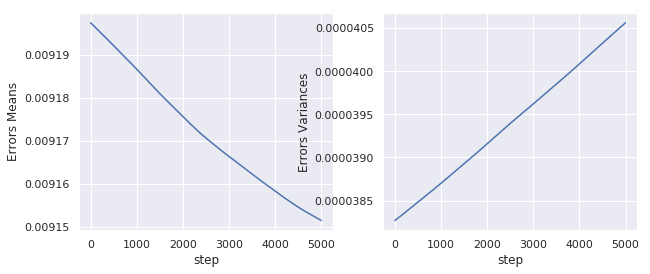

In [0]:
#delta_w = sys.float_info.min*10**302
def weights_plus_delta(layer_n, wb_n_n, if_print=False, delta = 10**-7):
  if if_print:
    print("------------------------------------------------------------")
    print("ΔW:", delta)
    print("\nOld weights of layer",layer_n, ", nodes", node_n, ":", model.layers[layer_n].trainable_variables[node_n])
  model.layers[layer_n].trainable_variables[node_n].assign(model.layers[layer_n].trainable_variables[node_n]+delta)
  if if_print:
    print("\nNew weights of layer",layer_n, ", nodes", node_n, ":", model.layers[layer_n].trainable_variables[node_n])
    
def model_plus_delta(): 
  weights_plus_delta(0,0, if_print=0)
  weights_plus_delta(0,1)
  weights_plus_delta(1,0)
  weights_plus_delta(0,1)

def fumble(x, y, steps = 5000, if_earlystop=True, if_plot=False):
  means = []
  variances = []
  mean_min = 1
  patience_n = 20
  patience = patience_n
  for i in range(steps):
    model_plus_delta()
    errors, mean_, var_ = get_errors(model, x, y, if_train=0)
    errors = [np.abs(e) for e in errors]
    mean = np.mean(errors)
    var = np.var(errors)
    means.append(mean)
    variances.append(var)

    if i>0:
      if mean >= means[-2]:
        patience = patience-1
        if patience<=0: break
      else:
        patience = patience_n
    
  if if_plot:  
    x = np.arange(len(means))
    
    plt.figure(figsize=(10, 4))
    plt.xticks(fontsize=10)
    plt.subplots_adjust(hspace=0.3)

    p1 = plt.subplot(121)
    p1.plot(x, means)
    plt.xlabel("step")
    plt.ylabel("Errors Means")
    
    p2 = plt.subplot(122)
    p2.plot(x, variances)
    plt.xlabel("step")
    plt.ylabel("Errors Variances")
    
  return means, variances

means, variances = fumble(x, y, if_plot=1)